In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
#import Pkg; Pkg.add("IJuliaBell")
using IJuliaBell
using ArraysOfArrays
using SummationByPartsOperators
using LinearAlgebra

nthreads = 2


## 2D PIC Escheleton 

Here we run the 2D version of PIC. 

In [2]:
include("aux_functions/aux_functions.jl")
include("aux_functions/inidat_aux_functions.jl")


f_x

### Initial Distribution

## Initial data configurations (Particles first)

In [3]:
## initial data configurations

trys = false
thermal = false
weibel = false
weibel_norel = false
#trys = true
#thermal = true
weibel = true
#weibel_norel = true




true

In [23]:
const order = 5
const D = 2


# Particle numbers
const N_exp = 5 #6
N = 10^(N_exp)

if  thermal
    run_name = "thermal_norel_"
    data_name = "par_dis_norel_thermal_"
    J = (100,100)
    Box_x = (0.0,1.0,0.0,1.0) 
    nm = [1,1]
    Box_array = [i for i in Box_x]
    k = 2π*nm./(Box_array[2:2:end]-Box_array[1:2:end-1]) # this here is k, not \hat{k}
    alpha_exp = 8
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, nm, Box_x)
    exp_Theta = 3
    θ = 10.0^(-exp_Theta)
    p_max = sqrt((1+10*θ)^2-1)
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_f_p = (θ,D)
    #par_f_p_1 = (θ,1,D) #to compute the norm of f_p
    #norm = int_mid_point_f(f_p_rel, par_f_p_1, [20_000,20_000], Box_p)
    #par_f_p_rel = (θ,norm,D)
    par_init = (α, nm)
    data_name = data_name * "nm_[$(nm[1]),$(nm[2])]_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box[2]-Box[1])x$(Box[4]-Box[3])_J_$(J[1])x$(J[2])_nm_[$(nm[1]),$(nm[2])]__Th$(exp_Theta)_alp$(alpha_exp)"
elseif weibel_norel
    run_name = "weibel_norel_"
    data_name = "par_dis_norel_weibel_"
    J = (100,100)
    Box_x = (0.0,1.0,0.0,1.0) 
    Ax = 1/2 # velocity anisotropy in the x direction
    alpha_exp = 8 # 8 so that is extremely small i.e. zero
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, [0.0,0.0], Box_x)
    exp_Theta = 3
    θ = 10.0^(-exp_Theta)
    p_max = sqrt((1+10*θ)^2-1)
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_f_p = (θ,D,Ax)
    par_init = (α, Ax)
    data_name = data_name * "Ax_(1d2)_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_Ax_(1d2)_Th$(exp_Theta)_alp$(alpha_exp)"
elseif weibel 
    run_name = "weibel_"
    data_name = "par_dis_rel_weibel_"
    J = (100,100)
    Box_x = (0.0,1.0,0.0,1.0) 
    Ax = 25 # velocity anisotropy in the x direction
    alpha_exp = 8 # 8 so that is extremely small i.e. zero
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, [0.0,0.0], Box_x)
    exp_Theta = 3
    θ1 = 10.0^(-exp_Theta)
    θ2 = Ax * θ1
    p_max = 10*θ2
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_init = (α, Ax)
    @show pars_f = (θ1,θ2,Ax)
    data_name = data_name * "Ax_$(Ax)_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_Ax_$(Ax)_Th$(exp_Theta)_alp$(alpha_exp)"
end



@show data_name 

# Evolution parameters
exp_t = 1.0 #2
t = 0.0
t_i = 0.0
t_f = 10.0^(exp_t)
M = 1001 #16001# 4001 # 81 # 2001 # time steps 
M_g = 11 #8001 #400 + 1 #number of outputs, starting from the initial data
dx = differentials(Box_x,J)
@show dx_max = maximum(dx)
@show dt = (t_f-t_i)/(M-1)


# for plotting and other things
x_p = [dx[1]*(i-1) for i in 1:J[1]] ;
y_p = [dx[2]*(i-1) for i in 1:J[2]] ;

Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box_x[1], xmax=Box_x[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box_x[3], xmax=Box_x[4], N=J[2])



@show par_evolv = (t_i, t_f, M, M_g, dt)
@show par_grid = (N, J, Box_x, order)
#@show pars_f = (θ1,θ2,)



println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")



run_name = run_name * "tf_$(convert(Int,t_f))_N$(N_exp)_M$(M)_o$(order)"
println(run_name)
println(data_name)


pars_f = (θ1, θ2, Ax) = (0.001, 0.025, 25)
data_name = "par_dis_rel_weibel_Ax_25_alp8_N5_Th3"
dx_max = maximum(dx) = 0.01
dt = (t_f - t_i) / (M - 1) = 0.01


par_evolv = (t_i, t_f, M, M_g, dt) = (0.0, 10.0, 1001, 11, 0.01)
par_grid = (N, J, Box_x, order) = (100000, (100, 100), (0.0, 1.0, 0.0, 1.0), 5)
t_f = 10.0, M = 1001, dt = 0.01, exp_Theta = 3
weibel_Box_1.0x1.0_J_100x100_Ax_25_Th3_alp8tf_10_N5_M1001_o5
par_dis_rel_weibel_Ax_25_alp8_N5_Th3


In [8]:
par_dis, run_name, pars, par_f_x, Box_x, par_f_p, Box_p = retrieve_initial_data_D("Initial_Distributions/" * data_name * ".jld2")
#@show data_name_from_inidat, pars, par_f_x, Box_x, par_f_p, Box_p

([0.669476545752844, 0.49294697661762865, -0.030379745781896783, 0.09215494300508353, 0.5326569618479964, 0.1173438629303113, 0.01677301128856379, -0.08104527116623056, 0.32991821228229967, 0.9939819170239349  …  -0.008118772464224433, -0.08064730639131751, 0.7040143100462987, 0.14006426115964787, 0.057242494864922056, 0.024879494554312542, 0.6398946988491334, 0.6634572085065977, -0.016186210636044196, -0.09949351300732545], "par_dis_rel_weibel_Ax_25_alp8_N5_Th3", (100000,), (1.0e-8, [0.0, 0.0], (0.0, 1.0, 0.0, 1.0)), (0.0, 1.0, 0.0, 1.0), (0.001, 0.025, [0.5, 0.0], 0.007760848597927437, 2), (-0.25, 0.25, -0.25, 0.25))

### Check Density

In [ ]:
plot(histogram2d(par_dis[1:2D:end],par_dis[2:2D:end], title="space distribution" ))

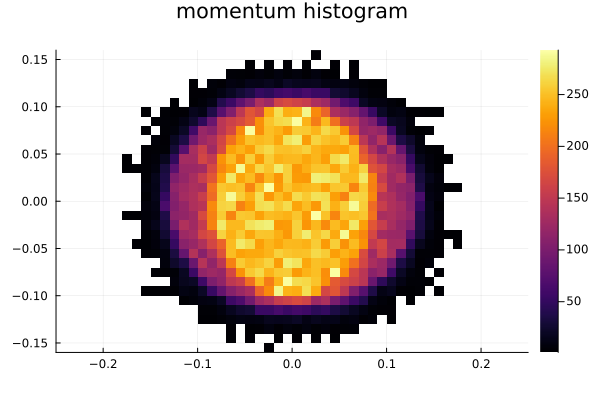

In [10]:
plot(histogram2d(par_dis[3:4:end],par_dis[4:4:end] )
,aspectratio=1
,title = "momentum histogram"
)

### Check Temperature

In [9]:
T = get_temperature_rel_D(par_dis,N,D)

0.0035020100176247023

In [12]:
par_grid = (N, Box_x, J, 5)
n = zeros(J)

get_density_2D!(par_dis, n, par_grid, 0.0)


100×100 Matrix{Float64}:
 8.50644e-5   7.65286e-5   8.05596e-5   …  7.70837e-5   8.08125e-5
 8.7539e-5    9.96953e-5   0.000101897     0.000107603  8.88141e-5
 9.64779e-5   8.32866e-5   8.825e-5        0.00011805   9.87958e-5
 0.000111391  8.41191e-5   9.63866e-5      8.94973e-5   0.000102125
 0.000126665  0.000101876  0.000116        7.83449e-5   0.000113756
 0.000101154  9.89704e-5   0.00010915   …  7.14205e-5   9.73408e-5
 8.52506e-5   0.000100925  0.000112729     7.97388e-5   8.26699e-5
 0.000107159  0.000103159  0.000110739     0.000107727  0.000103989
 0.000100988  0.000107985  0.000114433     0.000105255  0.000112943
 9.11524e-5   0.000109726  0.000101316     9.54661e-5   0.000101362
 ⋮                                      ⋱               
 0.000117668  9.60805e-5   8.90623e-5      9.11406e-5   0.000118896
 0.000125405  0.00012827   0.000111558     8.13671e-5   0.000116496
 0.000101856  9.87768e-5   0.000105604     8.89756e-5   0.000110827
 9.39034e-5   9.16295e-5   9.58408e-5  

In [ ]:
plot_matrix(n)

In [ ]:
#plot(n[:,5])

### Check Normalization

In [13]:
sum(n)

1.0000000000000002

### Check Current

In [14]:
par_grid = (N, J, Box_x, 5)
S = [0.0::Float64 for l in 1:2, i in 1:J[1], j in 1:J[2]]
TS = zeros(Float64,(2,J...,nthreads()))

par_current_threads_S = (par_grid, TS)

get_current_threads_2D!(par_dis, S, par_current_threads_S)
S[1,3,4]

-1.982633063637432e-6

In [ ]:
surface(y_p,x_p, S[1,:,:])

## Electric and Magnetic initial data

In [15]:
# We prescrive a constant magnetic field and the E is just a solution from Poisson's equations. 

B0 = 0.0 #initial magnetic field

B = [B0 for i in 1:J[1], j in 1:J[2]]

run_name = run_name * "_B0_$(convert(Int,B0))_"

"par_dis_rel_weibel_Ax_25_alp8_N5_Th3_B0_0_"

In [16]:
E = Array{Float64,3}(undef,(2,J...))
ρ = n.-1.0/prod(J)
@show sum(ρ)
get_E!(E,ρ,Box_x);

sum(ρ) = 2.1575623232461538e-17


In [ ]:
surface(y_p,x_p, E[2,:,:])

In [ ]:
plot(x_p, E[1,:,50])

In [17]:
average_outputs = false # detailed output (for runs which are too long)
full_outputs = false
animation = false # to run animations
phase_space_show = false #show phase space diagrams
#phase_space_show = true
remote_server = false # if run in remote_server as a script avoid all plots 
save_plots = false # put true is you want so save your plots.
full_outputs = true
animation = true

true

We build the initial data:

In [18]:
u = Vector{Float64}(undef, 4N + 3*prod(J)); # contains r, v and E and B

du = Vector{Float64}(undef, 4N + 3*prod(J)); # contains r, v and E

u[1:4N] = par_dis 

Fu = view(u,4N+1:4N+3*prod(J))

F = reshape(Fu,3,J...)

#F = view(u[4N+1:end],3,J...)
F[1:2,:,:] = E
F[3,:,:] = B;

# the total electric energy is:

(norm(E)^2 + norm(B)^2)*prod(dx)
#u
#F[3,:,:]



5.2514353839616406e-14

In [ ]:
#surface(y_p,x_p,F[1,:,:])

In [19]:
Energy_Ks, Energy_Es = get_energy_rel(u,(Box_x, N, J))

(0.0034931684657998415, 2.62571769198082e-14)

In [ ]:
#surface(y_p,x_p,F[3,:,:])

In [ ]:
u[4N+2*prod(J)+1:end]
#u[4N+1:end-prod(J)]

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

### What follows are characterizations of the initial data properties.

In [20]:

Coordinate_test(u,Box_x,N)

#println("n_total = $(sum(n .- 1.0))")
#println("v_total = $(sum(u[N+1:2N]))")
#println("E_total = $(sum(E_i))")

#println("S_total = $(sum(S))")

test passed


## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [21]:
if nthreads() > 1
TS = zeros(Float64, (2,J...,nthreads()))
p_RHS_D = (N, J, Box_x, order, n, S, du, get_density_2D!, get_current_threads_2D!, Interpolate_EBv_1, TS, Dx, Dy) ;
else
p_RHS_D = (N, J, Box_x, order, n, S, du, get_density_2D!, get_current_rel_2D!, Interpolate_EBv_1, Dx, Dy) ;
end


(100000, (100, 100), (0.0, 1.0, 0.0, 1.0), 5, [8.50644183707034e-5 7.652855364041492e-5 … 7.708366679768919e-5 8.081247090661311e-5; 8.753900051067659e-5 9.969525326423242e-5 … 0.00010760325203578622 8.881406907484593e-5; … ; 7.003320029738534e-5 6.818114984915e-5 … 9.309706162482611e-5 9.258051878749393e-5; 7.266142880020345e-5 6.0612131403228686e-5 … 7.322198547312886e-5 8.797407879001245e-5], [6.851787483463228e-8 2.870239312835741e-7 … -5.225900323048312e-7 8.436836691674864e-8; -7.194475837335671e-8 -5.83622725628228e-7 … 4.795621441751729e-7 -8.253251277710187e-8;;; 7.88162941792457e-7 1.2666912884129572e-6 … -2.690269484564129e-7 6.917509664727938e-8; -3.0500390931403655e-7 -3.372461959621237e-7 … -1.607651640873206e-7 4.424093208381993e-8;;; 9.133174495835123e-7 1.3929811390623473e-6 … -5.266586187578417e-7 -1.0243864636597887e-6; -3.9289821253312397e-7 -3.3656377720390225e-7 … 6.844667844557134e-7 3.368885535547313e-7;;; … ;;; -1.4852887224936503e-6 -2.254219913244987e-6 … -3.

In [24]:
t = 0.0
j = 1

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => pars_f)

if full_outputs
    run_name = run_name * "_full"
elseif average_outputs
    run_name = run_name * "_ave"
end

file_name = "Results/"* run_name * ".jld2"
#rm(file_name)




save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

if full_outputs
    field_name = "u"
    tiempo = @sprintf("%05d", j)
    jldopen(file_name, "a+") do file
        file[field_name * "/u_$(tiempo)"] = u;
    end
end

if average_outputs
    load_averages(file_name, j, par_grid, pars_f)
end

if animation
    par = Array{Float64,2}(undef,M_g,length(u));
    par[1,:] = u[:]
end

430000-element Vector{Float64}:
  0.669476545752844
  0.49294697661762865
 -0.030379745781896783
  0.09215494300508353
  0.5326569618479964
  0.1173438629303113
  0.01677301128856379
 -0.08104527116623056
  0.32991821228229967
  0.9939819170239349
  ⋮
 -2.8028698220816283e-7
 -5.882841775513662e-8
  0.0
 -2.771731483207372e-7
 -8.106636427773014e-8
  0.0
 -1.5325047434646773e-7
 -5.8590899239704914e-8
  0.0

In [ ]:
#RHS_D(u,t,p_RHS_D)

In [25]:
include("aux_functions/aux_functions.jl")
for k in 2:M
  RK4_Step!(RHS_D,u,t,dt,p_RHS_D)
  #global u = [make_periodic!(u[1:4N],Box_x); u[4N+1:end]]
  make_periodic!(u,Box_x,N)
  #filter_constant!(u[2N+1:end])
  global t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    local j = (k-1)÷(M÷(M_g-1))+1
    Energy_Ks, Energy_Es = get_energy_rel(u,(Box_x, N, J))

    if average_outputs
      load_averages(file_name, j, par_grid, pars_f)
    end

    if full_outputs
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
      end
    end

    println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Total_Energy = $(Energy_Ks + Energy_Es), E_Energy = $(Energy_Es)")

    if animation
      par[j,:] = u[:]
    end
  end
end

In [ ]:
j = 11

Plots.scatter(par[j,1:2D:4N], par[j,2:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "space", legend =:false)

png("weibel_space_t=10")

In [ ]:
include("aux_functions/aux_functions.jl")
par_v = par[10,:]
#make_periodic!(par_v,Box_x,N)
Coordinate_test(par_v,Box_x,N)

In [ ]:
j = 11

histogram(par[j,1:2D:4N], par[j,2:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "space", legend =:false)

In [ ]:
j = 11
Plots.scatter(par[j,3:2D:4N], par[j,4:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "momentum", legend =:false)

png("weibel_momentum_t=10")

In [ ]:
j = 11
Fuj = view(par[j,:],4N+1:4N+3*prod(J))

Fj = reshape(Fuj,3,J...)

#F = view(u[4N+1:end],3,J...)
Ej = Fj[1:2,:,:]
Bj = Fj[3,:,:];

#surface(y_p,x_p,Ej[2,:,:])
surface(y_p,x_p,Bj[:,:])

#norm(Bj)

In [ ]:
plot(Ej[2,:,50])

In [ ]:
#@bell sleep(3)
E_f = zeros(J)
#ϕ_f = zeros(J)
#n_f = zeros(J) #charge density
if Poisson
    get_density!(u, n, par_grid, 0.0)
    get_ϕ!(ϕ, n .- 1., κ)
    get_E_from_ϕ!(ϕ,E_f,dx)
end
if E_direct
    get_density!(u, n, par_grid, 0.5)
    get_E_direct!(E_f,-n .+ 1.0,par_grid)
end

plot(E_i, label="E_i")
plot!(E_f, label="E_f")
plot!(u[2N+1:end], ls=:dash, label="Dynamical E_f")
png("Images/" * run_name * "Constraint_preservation.png")

Saving the results

In [ ]:
if remote_server
    exit() #if running as script
end

In [ ]:
rfft(E_i)[nm+1]

## Studying the solutions: 

Post procesing is done in post_pro_landau_rel

### Energy:

34 peaks in T = 100, so $\omega = 0.34$

We save the data:

| time | order | energy | theta |
|------|-------|--------|-------|
|  40  |  1    | 7.4e-7 | 0.009978|
|  40  |  3    | 7.9e-8 | 0.009979 |
|  40  |  5    | 1.1e-7 | 0.009979 |
|  4000|  1    | 7.6e-5 | 0.009978 |
|  4000|  3    | 7.2e-6 | 0.010086 |
|  4000|  5    | 1.0e-5 | 0.010031 |
|  4e6 |  1    | 0.0360 | 0.010119 |
